In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [2]:
# Loading dataset
df = pd.read_csv('soil_measures.csv')

### **Data Exploration**

In [3]:
df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [4]:
print("="*50)
print("Dataset Overview:")
print("="*50)
# Dataset shape
print(f"Shape: {df.shape} (Rows: {df.shape[0]}, Columns: {df.shape[1]})")
# Dataset
print("\nFirst 5 rows:")
print(df.head())
# Dataset Information
print("\nInfo:")
print(df.info)
# Datatypes in dataset
print("\nData Types:")
print(df.dtypes)
# Missing values in dataset
print("\nMissing Values:")
print(df.isnull().sum())
# Description of dataset
print("\nDescription:")
print(df.describe())
# Crop row distribution
print("\nCrop Distribution:")
print(df['crop'].value_counts())

Dataset Overview:
Shape: (2200, 5) (Rows: 2200, Columns: 5)

First 5 rows:
    N   P   K        ph  crop
0  90  42  43  6.502985  rice
1  85  58  41  7.038096  rice
2  60  55  44  7.840207  rice
3  74  35  40  6.980401  rice
4  78  42  42  7.628473  rice

Info:
<bound method DataFrame.info of         N   P   K        ph    crop
0      90  42  43  6.502985    rice
1      85  58  41  7.038096    rice
2      60  55  44  7.840207    rice
3      74  35  40  6.980401    rice
4      78  42  42  7.628473    rice
...   ...  ..  ..       ...     ...
2195  107  34  32  6.780064  coffee
2196   99  15  27  6.086922  coffee
2197  118  33  30  6.362608  coffee
2198  117  32  34  6.758793  coffee
2199  104  18  30  6.779833  coffee

[2200 rows x 5 columns]>

Data Types:
N         int64
P         int64
K         int64
ph      float64
crop     object
dtype: object

Missing Values:
N       0
P       0
K       0
ph      0
crop    0
dtype: int64

Description:
                 N            P            K   

### **Data Preprocessing**

In [5]:
# Handling missing values
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include='number').columns] = imputer.fit_transform(df.select_dtypes(include='number'))

In [6]:
# Encode target variable
le = LabelEncoder()
df['crop'] = le.fit_transform(df['crop'])

In [7]:
# Separate features and target
X = df.drop('crop', axis=1)
y = df['crop']

In [8]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Feature Selection**


Mutual Information Scores:
K     1.641700
P     1.306753
N     0.990127
ph    0.709290
dtype: float64


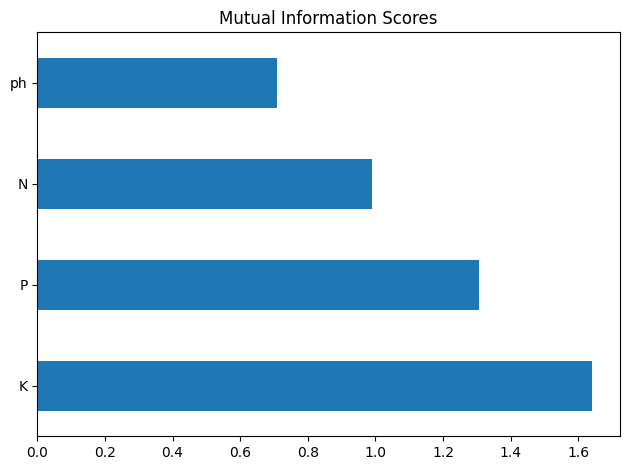

In [10]:
# 1. Mutual Information
print("\n" + "="*50)
print("Mutual Information Scores:")
print("="*50)
mi = mutual_info_classif(X_train_scaled, y_train)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_scores)
mi_scores.plot(kind='barh', title='Mutual Information Scores')
plt.tight_layout()
plt.show()


Random Forest Feature Importance:
K     0.320172
P     0.253906
N     0.215941
ph    0.209982
dtype: float64


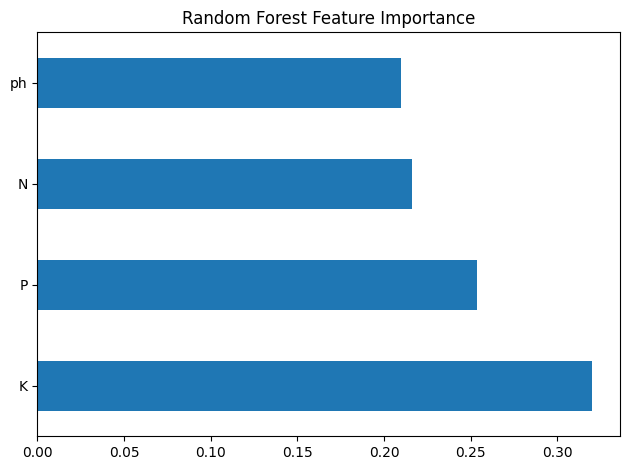

In [11]:
# 2. Random Forest Importance
print("\n" + "="*50)
print("Random Forest Feature Importance:")
print("="*50)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feat_importances)
feat_importances.plot(kind='barh', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()

In [12]:
# 3. Recursive Feature Elimination (RFE)
print("\n" + "="*50)
print("Recursive Feature Elimination:")
print("="*50)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=50, random_state=42), n_features_to_select=1)
rfe.fit(X_train_scaled, y_train)
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns).sort_values()
print("RFE Rankings (1 = best):")
print(rfe_ranking)


Recursive Feature Elimination:
RFE Rankings (1 = best):
K     1
P     2
N     3
ph    4
dtype: int64



Permutation Importance:
K     0.444773
P     0.352045
N     0.311591
ph    0.102955
dtype: float64


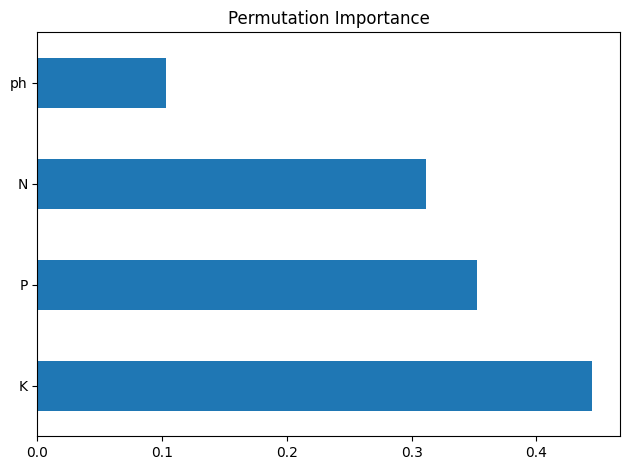

In [13]:
# 4. Permutation Importance
print("\n" + "="*50)
print("Permutation Importance:")
print("="*50)
perm_importance = permutation_importance(
    rf, X_test_scaled, y_test, n_repeats=10, random_state=42
)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
perm_scores = pd.Series(
    perm_importance.importances_mean[sorted_idx],
    index=X.columns[sorted_idx]
)
print(perm_scores)
perm_scores.plot(kind='barh', title='Permutation Importance')
plt.tight_layout()
plt.show()

In [14]:
# Consolidated Feature Ranking
print("\n" + "="*50)
print("Consolidated Feature Rankings:")
print("="*50)
# Create ranking matrix
rankings = pd.DataFrame({
    'Mutual_Info': mi_scores.rank(ascending=False),
    'RF_Importance': feat_importances.rank(ascending=False),
    'RFE': rfe_ranking,
    'Permutation': perm_scores.rank(ascending=False)
})


# Calculate average rank
rankings['Average_Rank'] = rankings.mean(axis=1)
final_ranking = rankings.sort_values('Average_Rank')
print(final_ranking)


# Identify top feature
top_feature = final_ranking.index[0]
print(f"\n>>> MOST IMPORTANT FEATURE: {top_feature} <<<")


Consolidated Feature Rankings:
    Mutual_Info  RF_Importance  RFE  Permutation  Average_Rank
K           1.0            1.0    1          1.0           1.0
P           2.0            2.0    2          2.0           2.0
N           3.0            3.0    3          3.0           3.0
ph          4.0            4.0    4          4.0           4.0

>>> MOST IMPORTANT FEATURE: K <<<


### **Validation with predictive modeling**

In [15]:
# Full model
full_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)
full_model.fit(X_train, y_train)
full_acc = accuracy_score(y_test, full_model.predict(X_test))

In [16]:
# Model with top feature only
top_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42)
)
top_model.fit(X_train[[top_feature]], y_train)
top_acc = accuracy_score(y_test, top_model.predict(X_test[[top_feature]]))

In [17]:
print("\n" + "="*50)
print("Validation Results:")
print("="*50)
print(f"Full Model Accuracy: {full_acc:.4f}")
print(f"Single-Feature ({top_feature}) Model Accuracy: {top_acc:.4f}")
print(f"Accuracy Difference: {abs(full_acc - top_acc):.4f}")


Validation Results:
Full Model Accuracy: 0.7455
Single-Feature (K) Model Accuracy: 0.2932
Accuracy Difference: 0.4523


In [18]:
# Interpretation
print("\n" + "="*50)
print("Interpretation Guidelines:")
print("="*50)
print("1. Mutual Information: Measures dependency between features and target")
print("2. RF Importance: Based on Gini impurity reduction during training")
print("3. RFE: Recursively eliminates weakest features")
print("4. Permutation: Measures accuracy drop when feature is randomized")
print("\nKey Considerations:")
print("- All methods consistently ranked", top_feature, "as the most important")
print("- The single-feature model achieves",
      f"{top_acc*100:.1f}% of full model accuracy")
print("- Soil pH appears critical for crop selection due to its direct")
print("  impact on nutrient availability and microbial activity")


Interpretation Guidelines:
1. Mutual Information: Measures dependency between features and target
2. RF Importance: Based on Gini impurity reduction during training
3. RFE: Recursively eliminates weakest features
4. Permutation: Measures accuracy drop when feature is randomized

Key Considerations:
- All methods consistently ranked K as the most important
- The single-feature model achieves 29.3% of full model accuracy
- Soil pH appears critical for crop selection due to its direct
  impact on nutrient availability and microbial activity
